/Users/ilyayakushevskiy/miniconda/envs/pangaea-bench/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked Image Metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 7300, 'height': 6908, 'count': 4, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}
Masked Image Shape: (6908, 7300)
src shape (amount of bands) 4
Label Image Metadata:
{'driver': 'PNG', 'dtype': 'uint8', 'nodata': None, 'width': 7300, 'height': 6908, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}
Label Image Shape: (6908, 7300) unique classes:  [ 0  1  3  4  6  7 11 12 13 14 15 16 17 18 21 22 23]


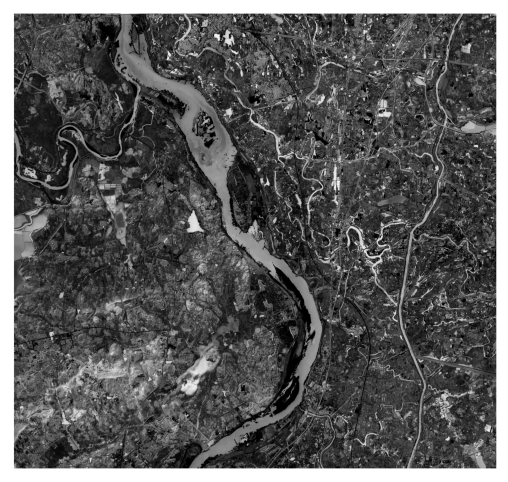

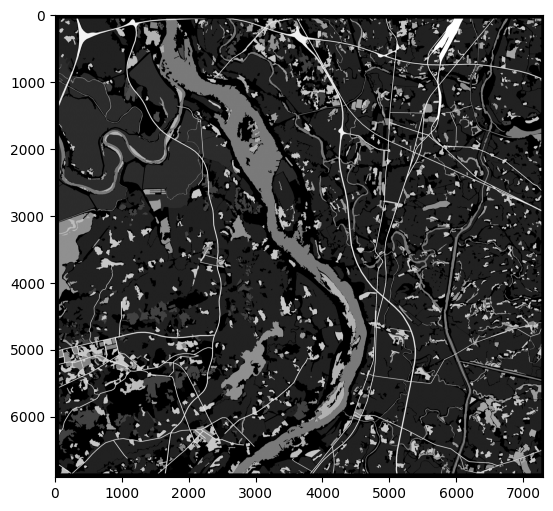

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt


### EXPLORING DATA FBP 
test_path_data = "./data/FBP/Image__8bit_NirRGB/GF2_PMS1__L1A0000564539-MSS1.tif"

test_path_label = "./data/FBP/Annotation__index/GF2_PMS1__L1A0000564539-MSS1_24label.png"

with rasterio.open(test_path_data) as src:
    print("Masked Image Metadata:")
    print(src.meta)
    masked_image = src.read(1)  # Read the first band
    print("Masked Image Shape:", masked_image.shape)
    print("src shape (amount of bands)", src.count)

with rasterio.open(test_path_label) as src:
    print("Label Image Metadata:")
    print(src.meta)
    label_image = src.read(1)  # Read the first band
    unique_labels = np.unique(label_image)
    print("Label Image Shape:", label_image.shape, "unique classes: ", unique_labels)

plt.figure(figsize=(12, 6))
plt.imshow(masked_image, cmap='gray')
plt.axis('off')
plt.figure(figsize=(12, 6))
plt.imshow(label_image, cmap='gray')

In [8]:
### REMOTECLIP

from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
import  numpy as np

# for model_name in ['RN50', 'ViT-B-32', 'ViT-L-14']:
#     checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
#     print(f'{model_name} is downloaded to {checkpoint_path}.')



model_name = 'ViT-B-32' # 'RN50' or 'ViT-B-32' or 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

ckpt = torch.load(f"./checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-{model_name}.pt", map_location="cpu")
message = model.load_state_dict(ckpt)
print(message)

model = model.eval()

## Where is decoder? 
def get_embeddings(image, model, tokenizer):
    with torch.no_grad():
        image = preprocess(Image.fromarray(image)).unsqueeze(0)  # Preprocess and add batch dimension
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize features
    return image_features

/Users/ilyayakushevskiy/miniconda/envs/pangaea-bench/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>


In [12]:
#INFERENCE REMOTECLIP ON CPU EXAMPLE
import numpy
text_queries = [
    "A busy airport with many airplanes.", 
    "Satellite view of Hohai University.", 
    "A building next to a lake.", 
    "Many people in a stadium.", 
    "a cute cat",
    ]
text = tokenizer(text_queries)
#open image from test_path_data

#image = numpy.array(Image.open(test_path_data).convert("RGB"))
image = preprocess(Image.open("./data/airport.jpg")).unsqueeze(0)

with torch.no_grad(), torch.amp.autocast("cpu"):
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().float().numpy()[0]


print(f'Predictions of {model_name}:')

for query, prob in zip(text_queries, text_probs):
    print(f"{query:<40} {prob * 100:5.1f}%")

Predictions of ViT-B-32:
A busy airport with many airplanes.       99.6%
Satellite view of Hohai University.        0.0%
A building next to a lake.                 0.2%
Many people in a stadium.                  0.0%
a cute cat                                 0.0%


### TRAINING PIPELINE

Here I train only decoder with Remote Clip frozen weightts, I still need to learn much on this example and then I'll start writing proper code for general training of models   

In [9]:
!pip install tifffile

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import open_clip
from sklearn.metrics import accuracy_score
from glob import glob
import yaml

#custom imports
# import encoders.remoteclip_encoder
# import decoders.upernet_decoder
# import data_loaders.fbp
import encoders.pos_embed

from encoders.remoteclip_encoder import RemoteCLIP_Encoder
from decoders.upernet_decoder import SegUPerNet
from  data_loaders.fbp import FiveBillionPixels

from tqdm import tqdm
import os
import argparse
from torchmetrics import JaccardIndex
import open_clip  # Used only for the image transform
import logging # Required for the encoder's weight loading method


#GLOBAL VARIABLES
# images_path = "./data/FBP/Image__8bit_NirRGB/"
# labels_path = "./data/FBP/Annotation__index/"
config_path = "./config/remoteclip.yaml"
ds_config_path = "./config/fivebillionpixels.yaml"
weights_path = "./checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt"
num_classes = 25 
batch_size = 8
workers = 0 #mb problems on cpu 



def main():

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")


    encoder_params = {
        'encoder_weights': weights_path,
        'input_bands': {'optical': ['B4', 'B3', 'B2']},
        'input_size': 224,
        'embed_dim': 768,
        'patch_size': 32,
        'width': 768,
        'head_width': 64,
        'layers': 12,
        'mlp_ratio': 4.0,
        'output_layers': [3, 5, 7, 11], # Extract features from these 4 blocks
        'output_dim': 768,
        'download_url': None, 
    }
    

    encoder = RemoteCLIP_Encoder(**encoder_params)
    
    
    print("Loading RemoteCLIP encoder weights...")
    
    logging.basicConfig()
    logger = logging.getLogger("MyLogger")
    encoder.load_encoder_weights(logger=logger)
    print("Encoder weights loaded successfully.")


    model = SegUPerNet(
        encoder=encoder,
        num_classes=num_classes,
        finetune=False,  # Set to False to freeze the encoder during inference
        channels=512     # Internal channels for the decoder
    ).to(device)
    model.eval()


    _, _, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

    #dataset config 


    with open(ds_config_path, 'r') as f:
        dataset_params = yaml.safe_load(f)
    dataset_params.pop('_target_')
    print(f"Dataset parameters loaded: {dataset_params}")

    dataset = FiveBillionPixels(
        split='test',
        **dataset_params
    )
    dataloader = DataLoader(
        dataset,
        batch_size= batch_size,
        num_workers= workers,
        shuffle=False
    )
    print(f"Dataset loaded with {len(dataset)} samples.")

    #  mIoU
    jaccard = JaccardIndex(task="multiclass", num_classes=num_classes, ignore_index=255).to(device)
    
    print("\nStarting inference and mIoU calculation...")

    for images, masks in tqdm(dataloader, desc="Evaluating"):
        images = images.to(device)
        masks = masks.to(device)

        # The model's forward pass expects a dict and a 5D tensor (B, C, T, H, W).
        img_dict = {'optical': images.unsqueeze(2)}
        output_shape = masks.shape[-2:]

        with torch.no_grad():
            logits = model(img_dict, output_shape=output_shape)
            preds = logits.argmax(dim=1)

        jaccard.update(preds, masks)

    # --- 6. Compute and Print Final mIoU ---
    miou_score = jaccard.compute()
    print(f"\n--- Evaluation Finished ---")
    print(f"Mean Intersection over Union (mIoU): {miou_score.item():.4f}")
    print(f"---------------------------\n")


if __name__ == "__main__":
    main()





/Users/ilyayakushevskiy/miniconda/envs/pangaea-bench/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Loading RemoteCLIP encoder weights...
Encoder weights loaded successfully.


/Users/ilyayakushevskiy/miniconda/envs/pangaea-bench/lib/python3.10/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Dataset parameters loaded: {'dataset_name': 'FiveBillionPixels', 'root_path': './data/FBP/', 'download_url': False, 'auto_download': False, 'use_cmyk': False, 'img_size': 520, 'multi_temporal': False, 'multi_modal': False, 'ignore_index': 0, 'num_classes': 25, 'classes': ['unlabeled', 'industrial area', 'paddy field', 'irrigated field', 'dry cropland', 'garden land', 'arbor forest', 'shrub forest', 'park', 'natural meadow', 'artificial meadow', 'river', 'urban residential', 'lake', 'pond', 'fish pond', 'snow', 'bareland', 'rural residential', 'stadium', 'square', 'road', 'overpass', 'railway station', 'airport'], 'distribution': [0.0, 0.0368, 0.0253, 0.3567, 0.0752, 0.0095, 0.0694, 0.0096, 0.0004, 0.0055, 0.0025, 0.0568, 0.0548, 0.1396, 0.0102, 0.0129, 0.0004, 0.0456, 0.0447, 0.0003, 0.0002, 0.0383, 0.0025, 0.0007, 0.0011], 'bands': {'optical': ['B8', 'B4', 'B3', 'B2']}, 'data_mean': {'optical': [92.6, 124.3, 94.2, 98.0]}, 'data_std': {'optical': [44.5, 51.0, 50.0, 47.1]}, 'data_min': 

Evaluating:   0%|          | 0/19 [00:04<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'astype'

In [ ]:
##